(0.46754446796632404, 1.732455532033676)


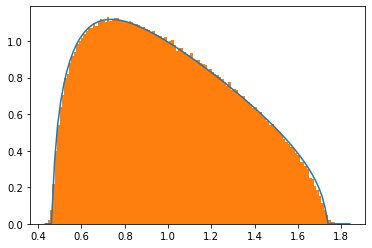

In [374]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

m = 75
n = 10*m
nsim = 10000

def marchenko_pastur_dens(x, p_div_n):
    y = p_div_n
    a, b = (1-np.sqrt(y))**2, (1+np.sqrt(y))**2
    if ((a < x) and (x < b)):
        return np.sqrt((b-x)*(x-a)) / (2*np.pi*x*y)
    else:
        return 0.0

w = np.ones(m)
bounds = lambda m,n : ((1 - np.sqrt(m/n))**2, (1 + np.sqrt(m/n))**2)
print(bounds(m,n))
mcorr = np.eye(m)
vol = np.ones(m)
mcov = np.diag(vol) @ mcorr @ np.diag(vol)
gen = stats.multivariate_normal(cov=mcov)

# estimators
data_eig = np.zeros((nsim, m))
for i in range(nsim):
    mcorr_hat = np.corrcoef(gen.rvs(n), rowvar=False)
    eigs = np.linalg.eigvals(mcorr_hat)
    data_eig[i] = eigs

eig_flat = data_eig.flatten()
x = np.linspace(np.min(eig_flat), np.max(eig_flat), 100)
y = [marchenko_pastur_dens(k, m/n) for k in x]
plt.plot(x,y)
plt.hist(data_eig.flatten(), bins='auto', density=True)
plt.show()